In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

# using Plots
using CairoMakie
using Random
using Printf
using DataFrames
using JLD
using StatsPlots
using LinearAlgebra
using NearestNeighbors
using DataInterpolations
using Clustering
using GraphMakie
using Graphs

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

df_current = filter(:n_traj=>x->x==2500,df);

evolutionary_runs = Dict{String,Any}("classical"=>df_current[:,"raw_data"][1],"feed_forward"=>df_current[:,"raw_data"][2],"mutual_inh"=>df_current[:,"raw_data"][3],"overlap_dom"=>df_current[:,"raw_data"][4]);

┌ Info: Scanning folder /Users/boothh/Documents/GRNEvoContingency/data/sims/repeated_evolution_different_topologies for result files.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:115
┌ Info: Added 13 entries.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:191


In [3]:
function refresh_type(v)
    [i for i in v]
end

function attach_column_to_tuples(column::Vector{Float64},tuples::Vector{Tuple{Float64,Float64}})
    return hcat(column,hcat(first.(tuples), last.(tuples)))
end

function tuples_to_matrix(tuples::Vector{Tuple{Float64,Float64}})
    return hcat(first.(tuples), last.(tuples))
end

tuples_to_matrix (generic function with 1 method)

In [16]:
mutable struct PhenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    pheno_traj :: Vector{Vector{Tuple{Float64, Float64}}}
    initial_fitness :: Float64
    initial_phenotype :: Tuple{Float64,Float64}

    full_pheno_traj :: Union{Vector{Vector{Tuple{Float64, Float64}}}, Nothing}
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    debug ::Any
end

function PhenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(map(x->x[2],et.fitness_trajectory)),evo_traces)
    pheno_traj = map(et->refresh_type(reduce(vcat,et.traversed_phenotypes)),evo_traces)

    initial_fitness = fitness_traj[1][1]
    initial_phenotype = pheno_traj[1][1]

    if initial_fitness < 0

        PhenoTrajectories(fitness_traj,pheno_traj,initial_fitness, initial_phenotype,nothing,nothing,nothing)
    else
        fitness_traj = map(x-> -1 .* x,fitness_traj)
        PhenoTrajectories(fitness_traj,pheno_traj,-initial_fitness, initial_phenotype,nothing,nothing,nothing)
    end

end

function interpolate_pheno_trajectories_by_fitness!(pt::PhenoTrajectories)

    full_pheno_traj = []

    for i in 1:length(pt.fitness_traj)
        unique_pheno_visits = unique(attach_column_to_tuples(pt.fitness_traj[i],pt.pheno_traj[i]), dims = 1)
        fitness_timestamps = unique_pheno_visits[:,1]
        itp_c = DataInterpolations.LinearInterpolation(unique_pheno_visits[:,2],fitness_timestamps);
        itp_w = DataInterpolations.LinearInterpolation(unique_pheno_visits[:,3],fitness_timestamps);
        fpt = [(itp_c(t),itp_w(t)) for t in pt.initial_fitness:1:0]
        push!(full_pheno_traj,fpt)
    end

    pt.full_pheno_traj = full_pheno_traj;
end


function cluster_pheno_trajectories!(pt::PhenoTrajectories,n_clusters::Int64,metric = SqEuclidean())

    fpt_mat = map(x->tuples_to_matrix(x),pt.full_pheno_traj)

    all_c = reduce(hcat,map(p->p[:,1],fpt_mat))
    all_w = reduce(hcat,map(p->p[:,2],fpt_mat))

    fpt_data = vcat(all_c,all_w);

    R = kmeans(fpt_data,n_clusters,distance = metric)

    pt.cluster_assignments = assignments(R);
    
end

function return_arrows(traj::Vector{Tuple{Float64,Float64}})

    traj_m = tuples_to_matrix(traj)

    all_diff_x = []
    all_diff_y = []

    x_s = []
    y_s = []

    for di in 1:size(traj_m,1)-1
        diff_x = traj_m[di+1,1] - traj_m[di,1]
        diff_y = traj_m[di+1,2] - traj_m[di,2]
        push!(all_diff_x,diff_x)
        push!(all_diff_y,diff_y)
        push!(x_s,traj_m[di,1])
        push!(y_s,traj_m[di,2])

    end

    return x_s, y_s, all_diff_x,all_diff_y
end

function cluster_density(pt :: Union{PhenoTrajectories,GenoTrajectories}, n_clusters::Int64)

    cm = countmap(pt.cluster_assignments)
    result = zeros(n_clusters)
    for cl in 1:n_clusters
        result[cl] = cm[cl] / length(pt.cluster_assignments)
    end
    return result
end




cluster_density (generic function with 1 method)

In [5]:
function plot_methodology_pheno_traj(pt::PhenoTrajectories, sample_choices::Vector{Int64}, topology_name::String, target = (40,20))

    fig = CairoMakie.Figure(resolution = (1600, 800))

    # sample_choices = [12,8]
    # sample_choices = [2,82]
    
    color_choices = [:red, :blue]

    # Contour plot

    xmin, x_max = (0,120)
    ymin, y_max = (0,120)

    c = LinRange(xmin, x_max, 200)
    w = LinRange(ymin, y_max, 200)

    z = -1 .* ( (c' .- target[1]).^2 .+ (w .- target[2]).^2 )

    gl = fig[1,1]

    ax1  = Axis(gl[1,1], backgroundcolor = "white", xlabel = "Centre position (cell id)", ylabel = "Stripe width (cells)", title = "Example phenotype trajectories for " * topology_name * " topology")

    c = CairoMakie.contourf!(ax1,c,w,transpose(z),levels = 10)

    path_n = 1

    for (sample_id,cc) in zip(sample_choices,color_choices)
        CairoMakie.scatter!(ax1,unique(pt.pheno_traj[sample_id]), label = "Trajectory " * string(path_n),markersize = 15., marker = :x,color = cc)
        CairoMakie.arrows!(ax1,return_arrows(unique(pt.pheno_traj[sample_id]))...,arrowsize  = 8.)

        path_n +=1
    end

    CairoMakie.scatter!(ax1,target,markersize = 20., marker = :●,label = "Target Phenotype", color = :purple)

    CairoMakie.axislegend()

    Colorbar(gl[1,2], c)

    # Comparison chart

    gr = fig[1,2]

    ax3  = Axis(gr[1,1], backgroundcolor = "white", xlabel = "Fitness", ylabel = "Centre position (cell id)", title = "Trajectory comparison - stripe center")
    ax4  = Axis(gr[2,1], backgroundcolor = "white", xlabel = "Fitness", ylabel = "Stripe width (cells)", title = "Trajectory comparison - stripe width")

    path_n = 1

    for (sample_id,cc) in zip(sample_choices,color_choices)

        data = unique(attach_column_to_tuples(pt.fitness_traj[sample_id],pt.pheno_traj[sample_id]),dims = 1)

        c_d = [ fc for fc in zip(data[:,1],data[:,2])]
        w_d = [ fw for fw in zip(data[:,1],data[:,3])]
        
        CairoMakie.scatter!(ax3,c_d, color = cc, label = "Trajectory " * string(path_n))
        CairoMakie.scatter!(ax4,w_d, color = cc, label = "Trajectory " * string(path_n))
        
        CairoMakie.lines!(ax3,c_d,color = cc,label = "Trajectory " * string(path_n) * " (Interpolation)")
        CairoMakie.lines!(ax4,w_d,color = cc,label = "Trajectory " * string(path_n) * " (Interpolation)")

        path_n +=1
    end

    CairoMakie.axislegend(position = :cb)

    fig
end


function plot_clustered_pheno_traj(pt::PhenoTrajectories, n_clusters::Int64, topology_name::String, target = (40,20))

    cluster_pheno_trajectories!(pt,n_clusters,SqEuclidean());

    fig = CairoMakie.Figure(resolution = (1600, 800))

    color_scheme = palette(:tab10)

    # Contour plot

    xmin, x_max = (0,120)
    ymin, y_max = (0,120)

    c = LinRange(xmin, x_max, 200)
    w = LinRange(ymin, y_max, 200)

    z = -1 .* ( (c' .- target[1]).^2 .+ (w .- target[2]).^2 )

    gl = fig[1,1]

    ax1  = Axis(gl[1,1], backgroundcolor = "white", xlabel = "Centre position (cell id)", ylabel = "Stripe width (cells)", title = "Clustered phenotype trajectories for " * topology * " topology; n_clusters = " * string(n_clusters) * ", n_samples = " * string(length(pt.fitness_traj)))

    c = CairoMakie.contourf!(ax1,c,w,transpose(z),levels = 10)

    for cl in 1:n_clusters

        cluster_traj = pt.full_pheno_traj[findall(x->x==cl, pt.cluster_assignments)]

        freq = length(findall(x->x==cl, pt.cluster_assignments))/length(pt.cluster_assignments)

        cluster_traj_m = map(x->tuples_to_matrix(x),cluster_traj)

        mc = mean(reduce(hcat,map(p->p[:,1],cluster_traj_m)),dims = 2)
        mw = mean(reduce(hcat,map(p->p[:,2],cluster_traj_m)),dims = 2)

        mean_traj = hcat(mc,mw)

        mean_traj_tuples = mapslices(x->(x[1],x[2]),mean_traj,dims = 2)[:,1]

        CairoMakie.lines!(ax1,mean_traj_tuples, label = "Cluster " * string(cl) * " Trajectories",linewidth = 6.,color = color_scheme[cl])
    end

    CairoMakie.scatter!(ax1,target,markersize = 20., marker = :●,label = "Target Phenotype", color = :purple)

    CairoMakie.axislegend()

    Colorbar(gl[1,2], c)

    # Barplot

    cd = cluster_density(pt, n_clusters)

    ocd_labels = sortperm(cd)

    ocd = cd[ocd_labels]

    gr = fig[1,2]

    ax2  = Axis(gr, backgroundcolor = "white", xlabel = "Cluster", ylabel = "Frequency",xticklabelsvisible=false,title = "Cluster association frequency")

    CairoMakie.barplot!(ax2,ocd, color = color_scheme[ocd_labels])

    ax2.xticks = ocd_labels

    return fig
end

plot_clustered_pheno_traj (generic function with 2 methods)

In [6]:
topology = "overlap_dom"

start_network = example_networks[topology]
run_data = evolutionary_runs[topology];

evo_traces = map(x->x[2],run_data);

In [7]:
pt = PhenoTrajectories(evo_traces);

interpolate_pheno_trajectories_by_fitness!(pt);

┌ Warning: Unsupported marker: ●, using ● instead
└ @ Makie /Users/boothh/.julia/packages/Makie/iY5BJ/src/conversions.jl:1260
┌ Warning: Unsupported marker: ●, using ● instead
└ @ Makie /Users/boothh/.julia/packages/Makie/iY5BJ/src/conversions.jl:1260


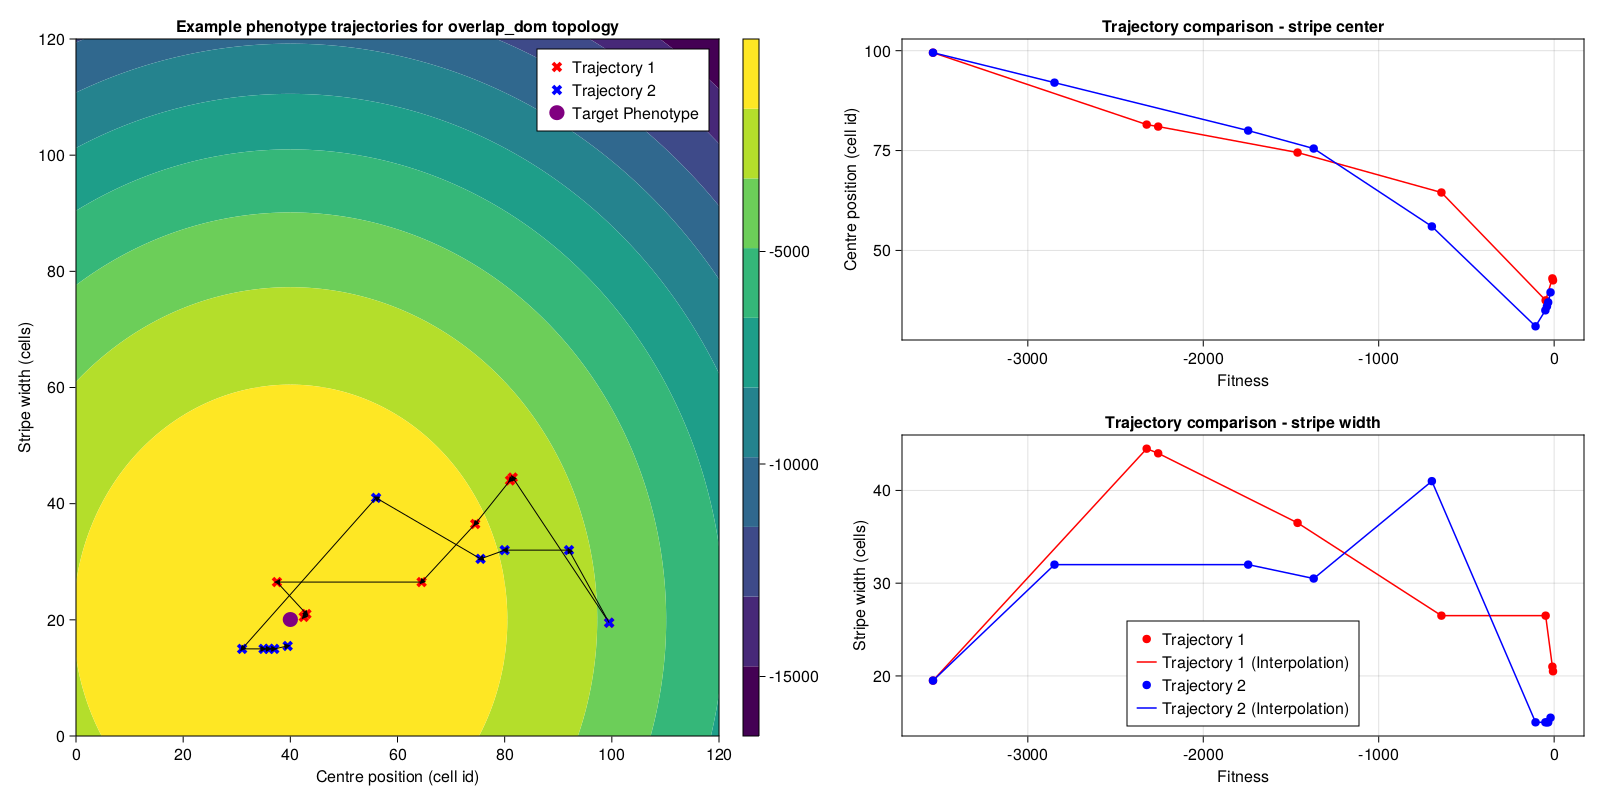

In [8]:
fig = plot_methodology_pheno_traj(pt, [12,8],topology, (40,20))

# CairoMakie.save(plotsdir("PhenoTrajectories",topology * "_methodology_example.png"),fig)

fig

┌ Warning: Unsupported marker: ●, using ● instead
└ @ Makie /Users/boothh/.julia/packages/Makie/iY5BJ/src/conversions.jl:1260
┌ Warning: Unsupported marker: ●, using ● instead
└ @ Makie /Users/boothh/.julia/packages/Makie/iY5BJ/src/conversions.jl:1260


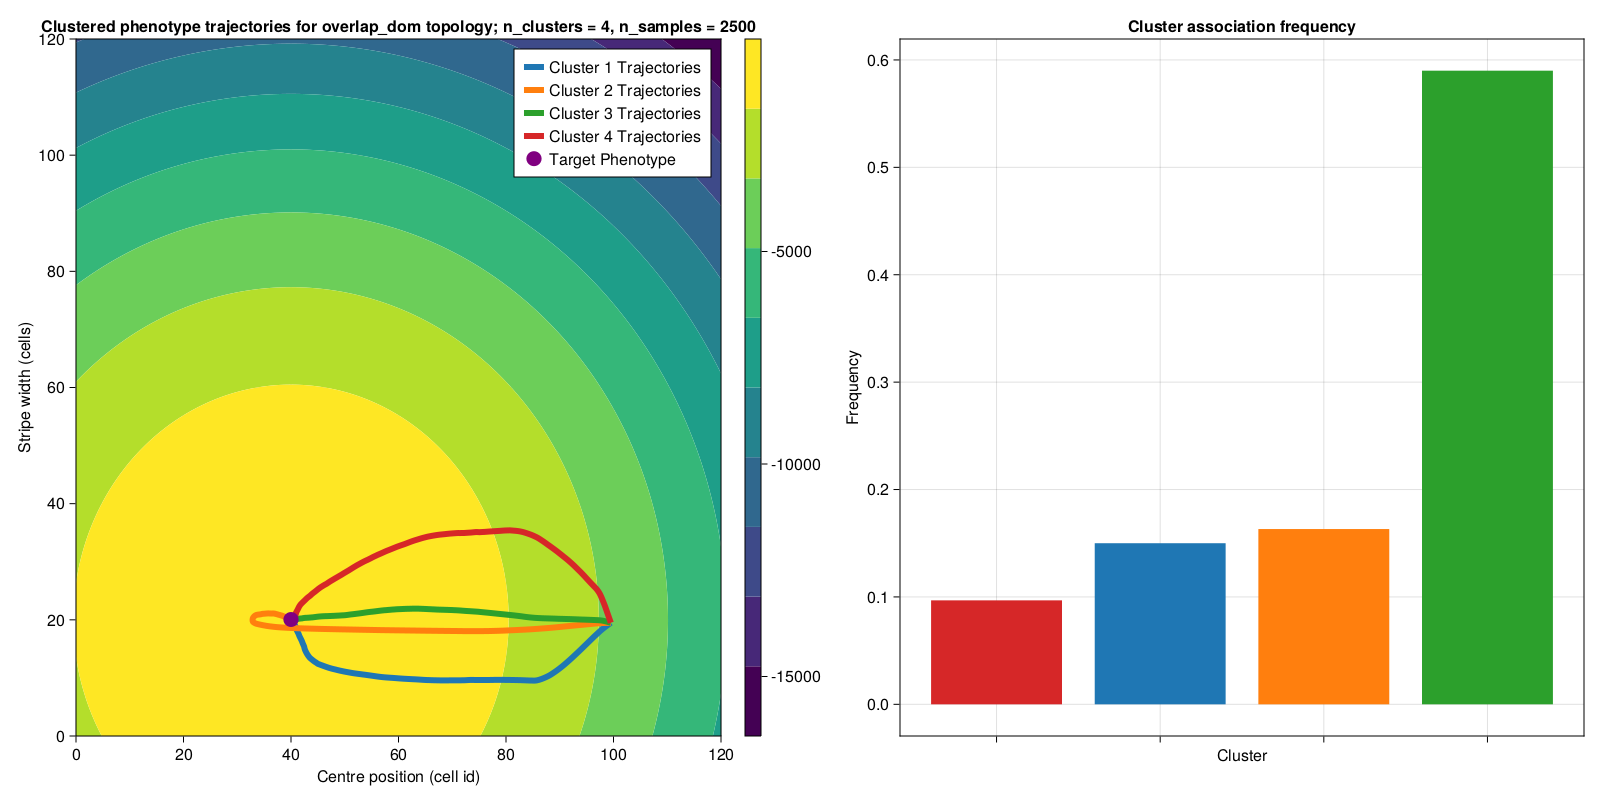

In [17]:
n_clusters = 4

fig = plot_clustered_pheno_traj(pt, n_clusters, topology, (40,20))

# CairoMakie.save(plotsdir("PhenoTrajectories",topology * "_clustered_pheno_traj_n_cluster = " * string(n_clusters) * ".png"),fig)

fig

In [10]:
# n_clusters = 4

# for topology in ["overlap_dom","classical","mutual_inh", "feed_forward"]

#     start_network = example_networks[topology]
#     run_data = evolutionary_runs[topology];

#     evo_traces = map(x->x[2],run_data);

#     pt = PhenoTrajectories(evo_traces);

#     interpolate_pheno_trajectories_by_fitness!(pt);

#     fig = plot_clustered_pheno_traj(pt, n_clusters, topology, (40,20))

#     CairoMakie.save(plotsdir("PhenoTrajectories",topology * "_clustered_pheno_traj_n_cluster = " * string(n_clusters) * ".png"),fig)

# end
        

In [11]:
mutable struct GenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    geno_traj :: Vector{Matrix{Float64}}
    initial_fitness :: Float64
    initial_genotype :: Vector{Float64}

    full_geno_traj :: Union{Vector{Matrix{Float64}}, Nothing}
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    debug ::Any
end

function GenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(map(x->x[2],et.fitness_trajectory)),evo_traces)
    geno_traj = map(et->reduce(hcat,map(x->vec(x),et.traversed_topologies)),evo_traces);

    initial_fitness = fitness_traj[1][1]
    initial_genotype = vec(evo_traces[1].traversed_topologies[1])

    if initial_fitness < 0

        GenoTrajectories(fitness_traj,geno_traj,initial_fitness, initial_genotype,nothing,nothing,nothing)
    else
        fitness_traj = map(x-> -1 .* x,fitness_traj)
        GenoTrajectories(fitness_traj,geno_traj,-initial_fitness, initial_genotype,nothing,nothing,nothing)
    end
end

function interpolate_geno_trajectories_by_fitness!(gt::GenoTrajectories)

    full_geno_traj = []

    for i in 1:length(gt.fitness_traj)
        full_weight_traj = zeros(size(gt.geno_traj[i],1),length(gt.initial_fitness:1:0))
        for wi in 1:size(gt.geno_traj[i],1)
            unique_geno_visits = unique(hcat(gt.fitness_traj[i],gt.geno_traj[i][wi,:]), dims = 1)
            fitness_timestamps = unique_geno_visits[:,1]
            itp_g = DataInterpolations.ConstantInterpolation(unique_geno_visits[:,2],fitness_timestamps);
            full_weight_traj[wi,:] = [itp_g(t) for t in gt.initial_fitness:1:0]
        end
        push!(full_geno_traj,full_weight_traj)
    end

    gt.full_geno_traj = full_geno_traj;
end

function cluster_geno_trajectories!(gt::GenoTrajectories,n_clusters::Int64,metric = SqEuclidean())

    fgt_data = hcat(map(x->vec(x),gt.full_geno_traj)...)

    R = kmeans(fgt_data,n_clusters,distance = metric)

    gt.cluster_assignments = assignments(R);
end

function cluster_geno_trajectories!(gt::GenoTrajectories,n_clusters::Int64,weight_n::Int64,metric = SqEuclidean())

    fgt_data = hcat(map(x->x[weight_n,:],gt.full_geno_traj)...)

    R = kmeans(fgt_data,n_clusters,distance = metric)

    gt.cluster_assignments = assignments(R);
end

function concat_matrices(v_m)

    r = zeros((size(v_m[1])...,length(v_m)))

    for i in 1:length(v_m)

        r[:,:,i] = v_m[i]

    end

    return r

end


concat_matrices (generic function with 1 method)

In [12]:
function select_marker(edge_value)
    edge_value > 0 ? :ltriangle : :vline
end

function draw_grn(network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.03, -0.05],
                [0.01, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    f, ax, p = graphplot(ng,layout = fixed_layout,node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]))

    p.elabels_rotation[] = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng))

    # offsets = 0.05 * (p[:node_pos][] .- p[:node_pos][][1])
    p.nlabels_offset[] = offsets

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)

    f,ax,p
end

function draw_grn!(ax,network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.075, -0.05],
                [0.025, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    graphplot!(ax,ng,layout = fixed_layout, node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]), elabels_rotation = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng)),nlabels_offset = offsets)

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)
end


draw_grn! (generic function with 1 method)

In [13]:
gt = GenoTrajectories(evo_traces);

interpolate_geno_trajectories_by_fitness!(gt);

In [18]:
function plot_methodology_geno_traj(gt::GenoTrajectories, sample_choices::Vector{Int64}, topology_name::String)

    fig = CairoMakie.Figure(resolution = (1800, 1000))

    color_scheme = palette(:tab10)

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]

    # sample_choices = [12,2258]

    # Comparison chart

    gr = fig[1,2]

    full_fitness_traj = collect(gt.initial_fitness:1:0)

    for i in 1:length(sample_choices)

        ax  = Axis(gr[i,1], backgroundcolor = "white", xlabel = "Fitness", ylabel = "Weight Value", title = "Evolutionary weight trajectory - example " * string(i))

        s_id = sample_choices[i]

        for wi in 1:10
            CairoMakie.lines!(ax,full_fitness_traj,gt.full_geno_traj[s_id][wi,:],color = color_scheme[wi],linewidth = 3.,label = "Weight " * weight_names[wi])
            CairoMakie.scatter!(ax,[t for t in zip(gt.fitness_traj[s_id],gt.geno_traj[s_id][wi,:])],color = color_scheme[wi])
        end

    end


    # leg = Legend(fig[1,1], ax)

    # ax3  = Axis(fig[1,3], backgroundcolor = "white")

    ax3  = Axis(fig[1,1], backgroundcolor = "white", title = topology_name * " - start network")

    draw_grn!(ax3,reshape(gt.initial_genotype,(3,4)),color_scheme)

    gr = fig[1,3]

    for i in 1:length(sample_choices)

        if i == 1
            ax  = Axis(gr[i,1], backgroundcolor = "white",title = "Evolved networks")
        else
            ax  = Axis(gr[i,1], backgroundcolor = "white")
        end

        s_id = sample_choices[i]

        draw_grn!(ax,reshape(gt.geno_traj[s_id][:,end],(3,4)),color_scheme)
    end

    return fig

end


plot_methodology_geno_traj (generic function with 1 method)

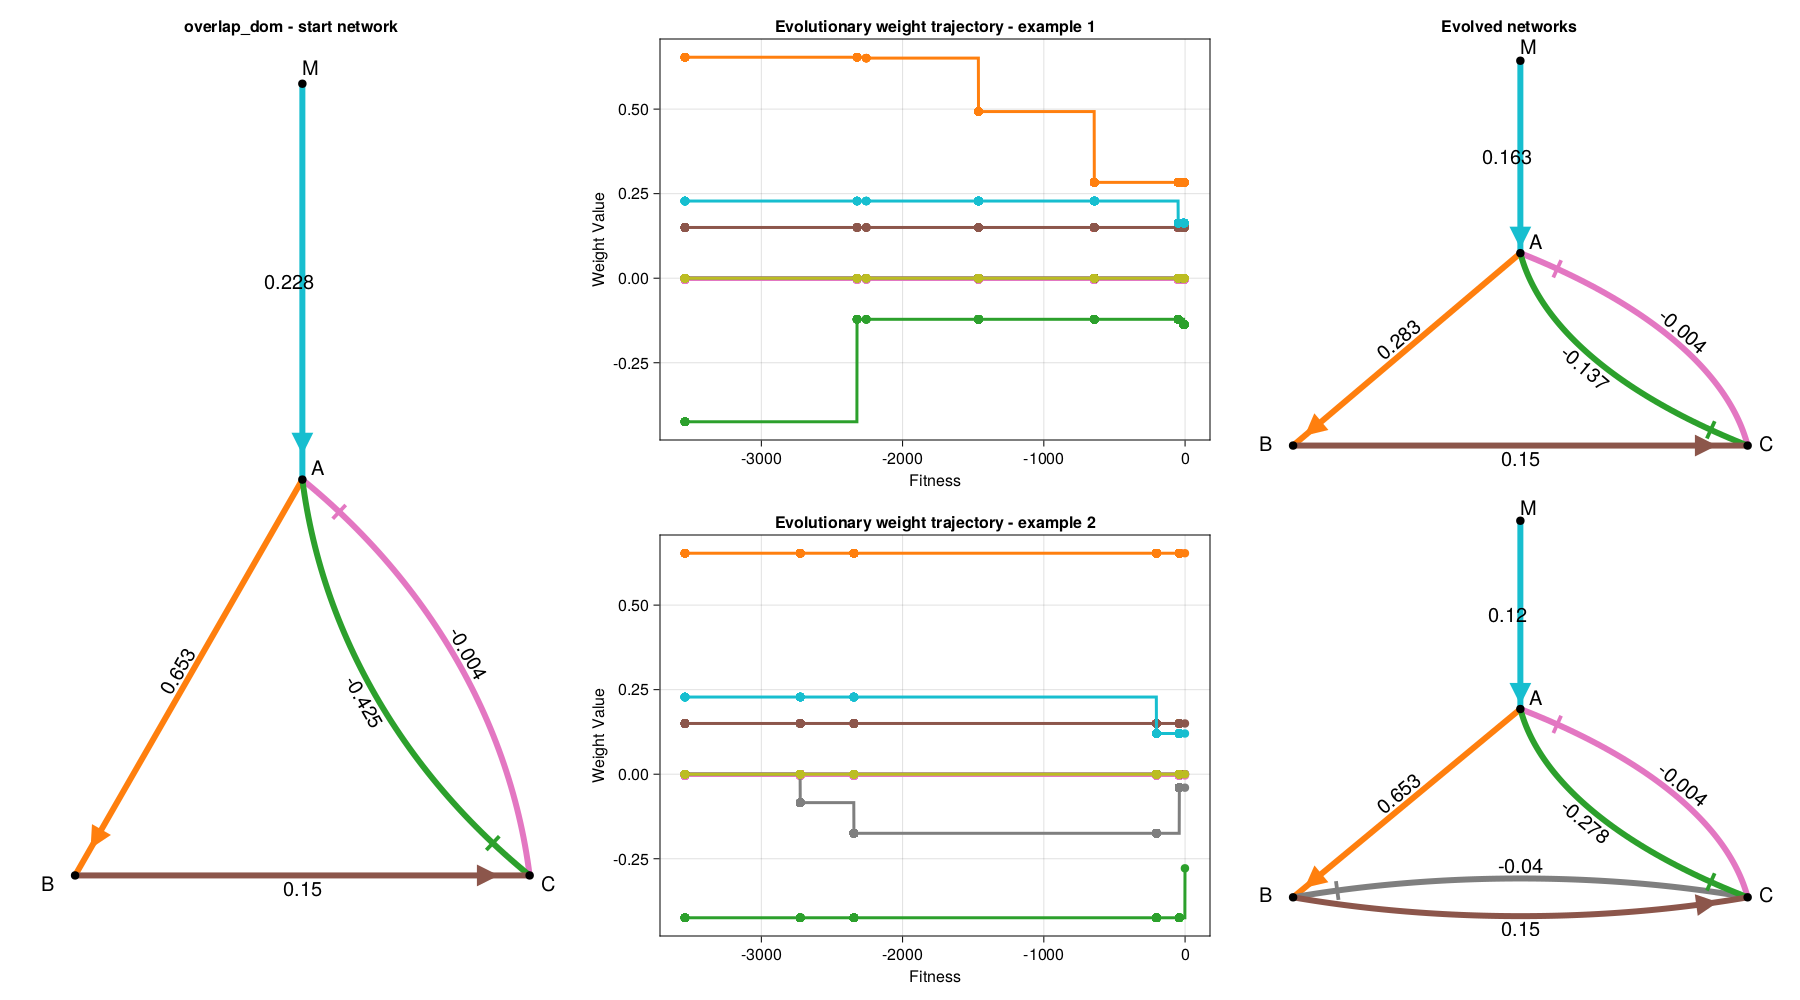

In [19]:
fig = plot_methodology_geno_traj(gt, [12,2258], topology)

# CairoMakie.save(plotsdir("GenoTrajectories",topology * "_methodology_example.png"),fig)

In [20]:
# cluster_geno_trajectories!(gt,n_clusters,SqEuclidean());

In [25]:
function plot_clustered_geno_traj(gt::GenoTrajectories, n_clusters::Int64, topology_name::String)

    cluster_geno_trajectories!(gt,n_clusters,SqEuclidean());
    
    res = 1000

    fig = CairoMakie.Figure(resolution = (res + 2.5*res/n_clusters, res))

    color_scheme = palette(:tab10)

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]

    gl = fig[1,2:4]

    grid_entries = Tuple.(findall(x-> x> 0,ones(Int64(ceil(sqrt(n_clusters))),Int64(ceil(sqrt(n_clusters))))))

    full_fitness_traj = collect(gt.initial_fitness:1:0)

    ax_list = []

    for cl in 1:n_clusters

        ass_cl = gt.full_geno_traj[findall(x->x==cl,gt.cluster_assignments)];

        all_m = concat_matrices(ass_cl)

        mt = mean(all_m,dims = 3)[:,:,1]
        std_t = std(all_m,dims = 3)[:,:,1]

        ax1  = Axis(gl[grid_entries[cl]...], backgroundcolor = "white", xlabel = "Fitness", ylabel = "Weight value", title = "Cluster " * string(cl))

        for i in 1:10
            CairoMakie.lines!(ax1,full_fitness_traj,mt[i,:], label = "Weight " * weight_names[i],color = color_scheme[i],linewidth = 5.)
            CairoMakie.band!(ax1,full_fitness_traj,mt[i,:] .- std_t[i,:],mt[i,:] .+ std_t[i,:],color = (color_scheme[i],0.5))
        end

        push!(ax_list,ax1)

    end

    gr = fig[1,1]

    leg = Legend(gr, ax_list[1])

    # Barplot

    gbp = fig[1,5]

    cd = cluster_density(gt, n_clusters)

    ocd_labels = sortperm(cd)

    ocd = cd[ocd_labels]

    ax2  = Axis(gbp[1,1], backgroundcolor = "white", xlabel = "Cluster", ylabel = "Frequency",xticks = (1:length(ocd_labels),string.(ocd_labels)),title = "Cluster association frequency")

    CairoMakie.barplot!(ax2,ocd)

    # GRN

    ax3  = Axis(gbp[2,1], backgroundcolor = "white",title = topology_name * " - start network")

    draw_grn!(ax3,reshape(gt.initial_genotype,(3,4)),color_scheme)

    return fig
end

plot_clustered_geno_traj (generic function with 1 method)

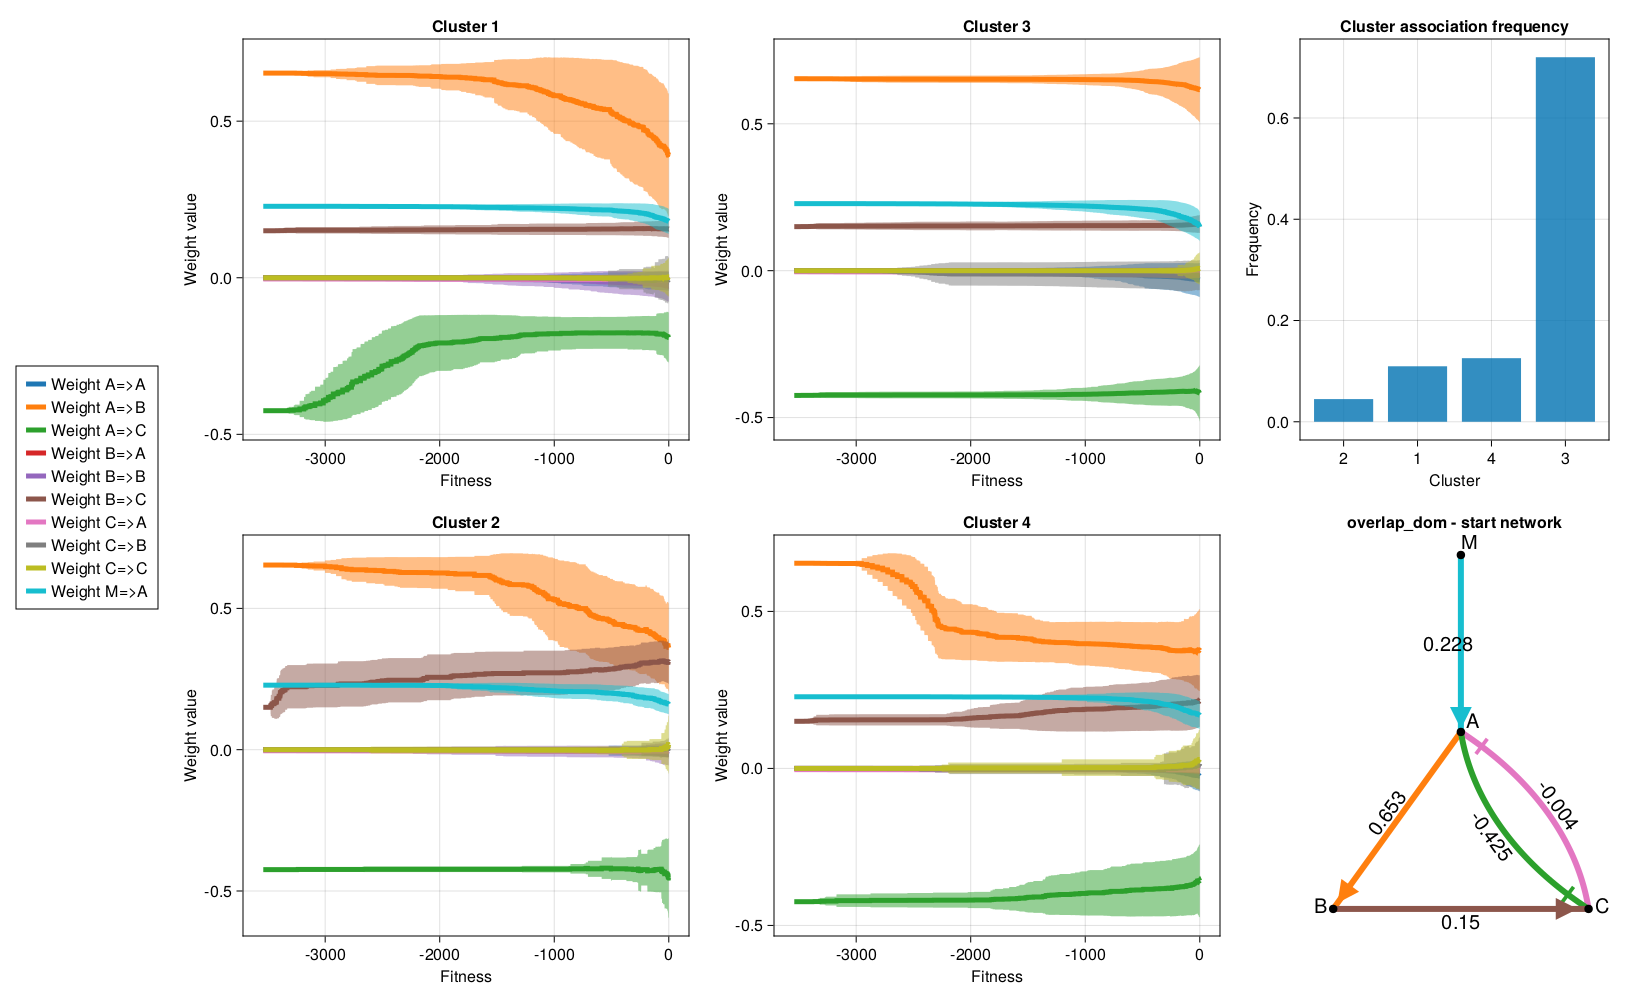

In [26]:
plot_clustered_geno_traj(gt, n_clusters, topology)

In [27]:
# n_clusters = 4

# for topology in ["overlap_dom","classical","mutual_inh", "feed_forward"]

#     start_network = example_networks[topology]
#     run_data = evolutionary_runs[topology];

#     evo_traces = map(x->x[2],run_data);

#     gt = GenoTrajectories(evo_traces);

#     interpolate_geno_trajectories_by_fitness!(gt);

#     fig = plot_clustered_geno_traj(gt, n_clusters, topology)

#     CairoMakie.save(plotsdir("GenoTrajectories",topology * "_clustered_geno_traj_n_cluster = " * string(n_clusters) * ".png"),fig)

# end